In [1]:
import os, math
from collections import defaultdict, namedtuple, deque
import dataclasses
from dataclasses import dataclass
import itertools
from enum import StrEnum, auto
import sqlite3
import logging
import logging.handlers
import pickle
import datetime
import multiprocessing as mp

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_1024'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()
    
print(f'xp = {xp.__name__}')

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name))
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name))

mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, fork method leads to failures in bootstrap somewhere around CUDA

xp = numpy


In [3]:
%run sequencing_sp.ipynb

In [4]:
DF_TEST_RESULTS = pd.DataFrame(columns=['test_run_id', 'config_variant', 'cortical_columns', 'train_images_count', 'train_runs',
                                        'source_ds', 'test_image_id', 'true_value', 'infer_value', 'sim'])
TRAIN_RUN_ID = 0
TEST_RUN_ID = 0

In [5]:
hdc = Hdc(10_000, xp)

In [6]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 5.01 μs


((100, 5), (20, 5))


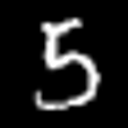
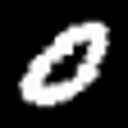
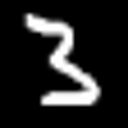
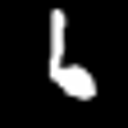
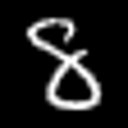
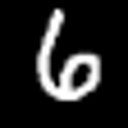
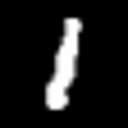
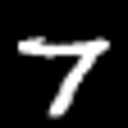
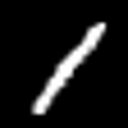
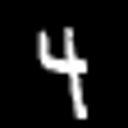
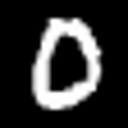
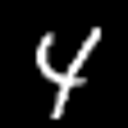
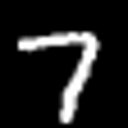
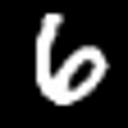
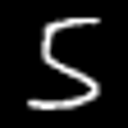
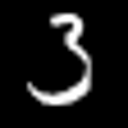

In [7]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [8]:
COS_SIM_45 = np.sqrt(2) / 2
COS_SIM_30 = np.sqrt(3) / 2

In [9]:
SeqLatentVec = namedtuple('SeqVec', 'engram_id seq_index si_ind lv')
Engram = namedtuple('Engram', 'engram_id, image_id value seq_lvs')
    
HISTORY_LEN = 5
LATENT_VECTOR_LEN = (1 + HISTORY_LEN) * 4

In [42]:
def _calc_connection_vector(si_ind_from, si_ind_to, sensor_instance_ind_dict):
    si_from = sensor_instance_ind_dict[si_ind_from]
    si_to = sensor_instance_ind_dict[si_ind_to]
    return np.array([si_to.x - si_from.x, si_to.y - si_from.y])

def _calc_normal_vector(si_ind, sensor_instance_ind_dict):
    si = sensor_instance_ind_dict[si_ind]
    return np.array([si.normal_vec.real, si.normal_vec.imag])
    
def calc_si_connection_vectors(sequences, sensor_instance_ind_dict):
    connection_vectors_list = []
    
    for seq in sequences:
        seq_pairs = zip(seq[-1:] + seq[:-1], seq)
        cv = list(map(lambda si_inds: _calc_connection_vector(si_inds[0], si_inds[1], sensor_instance_ind_dict), seq_pairs))
        cv = np.array(cv)
        connection_vectors_list.append(cv)

    return connection_vectors_list

def calc_si_latent_vectors(sequences, sensor_instance_ind_dict):
    sensor_instance_ind_to_latent_vector = {}
    
    for seq in sequences:
        normal_vectors = list(map(lambda si_ind: _calc_normal_vector(si_ind, sensor_instance_ind_dict), seq))
        
        seq_pairs = zip(seq[-1:] + seq[:-1], seq)
        connection_vectors = list(map(lambda si_inds: _calc_connection_vector(si_inds[0], si_inds[1], sensor_instance_ind_dict), seq_pairs))
        connection_vectors = np.array(connection_vectors)
        connection_vectors = (connection_vectors.T / np.linalg.norm(connection_vectors, axis=1)).T
        
        neighbours_count_for_seq = min(HISTORY_LEN, len(seq) - 1)
        
        # look-behind
        pre_vecs = deque()

        for i, si_ind in enumerate(seq[-neighbours_count_for_seq:]):
            normal_vector = normal_vectors[-neighbours_count_for_seq+i]
            connection_vector = connection_vectors[-neighbours_count_for_seq+i]
            pre_vecs.appendleft(np.hstack([normal_vector, connection_vector]))

        # look-ahead
        # post_vecs = deque()

        # for i, si_ind in enumerate(seq[1:1+neighbours_count_for_seq]):
        #     normal_vector = normal_vectors[i]
        #     connection_vector = connection_vectors[i]
        #     post_vecs.append(np.hstack([normal_vector, connection_vector]))

        # i_for_last_post = 0 + neighbours_count_for_seq
        # assert len(pre_vecs) == len(post_vecs)
        pads = [np.array([0, 0, 0, 0])] * (HISTORY_LEN - neighbours_count_for_seq)
        
        for i, si_ind in enumerate(seq):
            # print(f'{i} {si_ind}')
            # print(f'{i} {si_ind} {connection_vectors[i]}')
            # print(f'{i} {si_ind} {pre_vecs}')
            latent_vector = []

            latent_vector_head = np.hstack([normal_vectors[i], connection_vectors[i]])
            latent_vector.append(latent_vector_head)
            latent_vector.append(np.array(list(pre_vecs) + pads).ravel())
            # latent_vector.append(np.array(list(post_vecs) + pads).ravel())
            
            latent_vector = np.hstack(latent_vector)
            # print(f'{i} {si_ind} {latent_vector}')
            assert latent_vector.shape == (LATENT_VECTOR_LEN,), latent_vector.shape
            latent_vector = latent_vector / np.linalg.norm(latent_vector)
            sensor_instance_ind_to_latent_vector[si_ind] = latent_vector
    
            pre_vecs.pop()
            pre_vecs.appendleft(latent_vector_head)
            assert len(pre_vecs) == neighbours_count_for_seq

            # post_vecs.popleft()
            # i_for_last_post += 1
            # i_for_last_post = 0 if i_for_last_post >= len(seq) else i_for_last_post
            # post_vecs.append(np.hstack([normal_vectors[i_for_last_post], connection_vectors[i_for_last_post]]))
            # assert len(post_vecs) == neighbours_count_for_seq
        
    return sensor_instance_ind_to_latent_vector

def calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict):
    connection_vector_lengths = np.linalg.norm(connection_vectors, axis=1)
    seq_path_length = connection_vector_lengths.sum()
    seq_lv = np.zeros(1000, dtype='F')
    k = seq_lv.shape[0] / seq_path_length
    i = 0
    si_ind_to_offset = {}

    # Build sequence latent vector from a fixed number of normals - stretched or shrinked version of sequences as normals
    for si_ind, con_vec, con_vec_len in zip(seq, connection_vectors, connection_vector_lengths):
        i_from = int(i)
        i += con_vec_len * k
        i_to = min(int(i), seq_lv.shape[0] - 1)
        assert i_from >= 0, i_from
        assert i_to >= i_from, (i_to, i_from)
        assert i_to < seq_lv.shape[0], (i_to, seq_lv.shape[0])
        seq_lv[i_from:i_to] = sensor_instance_ind_dict[si_ind].normal_vec # repetition due to broadcasting
        si_ind_to_offset[si_ind] = i_from

        if i_to == seq_lv.shape[0] - 1:
            break

    return seq_lv, si_ind_to_offset

In [43]:
LATENT_VECTORS = HdvArray(LATENT_VECTOR_LEN, xp) # aka hooks, all vectors are normalized
SEQ_LV_DICT = {}
ENGRAM_DICT = {}
ENGRAM_ID_SOURCE = itertools.count(1)

In [44]:
%%time

train_runs = 1
count = min(100, len(df_train_images))

for _ in tqdm(range(train_runs)):
    TRAIN_RUN_ID += 1
    image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)
    # image_ids = [28977]
    # image_ids = [10415]

    for image_id in image_ids:
        df_image = df_train_images.loc[image_id]
        sensor_instance_ind_dict = pickle.loads(df_image['si'])
        sequences_full = pickle.loads(df_image['seq'])
        sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)
        sensor_instance_ind_to_latent_vector = calc_si_latent_vectors(sequences, sensor_instance_ind_dict)
        connection_vectors_list = calc_si_connection_vectors(sequences, sensor_instance_ind_dict)
        assert len(connection_vectors_list) == len(sequences)

        engram = Engram(next(ENGRAM_ID_SOURCE), image_id, str(df_image['value']), [])
        ENGRAM_DICT[engram.engram_id] = engram

        for seq_index, (seq, connection_vectors)  in enumerate(zip(sequences, connection_vectors_list)):
            # connection_vector_lengths = np.linalg.norm(connection_vectors, axis=1)
            # seq_path_length = connection_vector_lengths.sum()
            # seq_lv = np.zeros(1000, dtype='F')
            # k = seq_lv.shape[0] / seq_path_length
            # i = 0
            # si_ind_to_offset = {}

            # # Build sequence latent vector from a fixed number of normals - stretched or shrinked version of sequences as normals
            # for si_ind, con_vec, con_vec_len in zip(seq, connection_vectors, connection_vector_lengths):
            #     i_from = int(i)
            #     i += con_vec_len * k
            #     i_to = min(int(i), seq_lv.shape[0] - 1)
            #     assert i_from >= 0, i_from
            #     assert i_to >= i_from, (i_to, i_from)
            #     assert i_to < seq_lv.shape[0], (i_to, seq_lv.shape[0])
            #     seq_lv[i_from:i_to] = sensor_instance_ind_dict[si_ind].normal_vec # repetition due to broadcasting
            #     si_ind_to_offset[si_ind] = i_from

            #     if i_to == seq_lv.shape[0] - 1:
            #         break
            seq_lv, si_ind_to_offset = calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict)
                
            for i, si_ind in enumerate(seq):
                rolled_seq_lv = np.roll(seq_lv, -si_ind_to_offset[si_ind])
                seq_lv_boxed = SeqLatentVec(engram.engram_id, seq_index, si_ind, rolled_seq_lv)
                engram.seq_lvs.append(seq_lv_boxed)

                lv = sensor_instance_ind_to_latent_vector[si_ind]
                latent_vector_i = LATENT_VECTORS.lease()
                LATENT_VECTORS.array_active[latent_vector_i] = lv
                
                SEQ_LV_DICT[latent_vector_i] = seq_lv_boxed                

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 178 ms, sys: 869 μs, total: 178 ms
Wall time: 176 ms


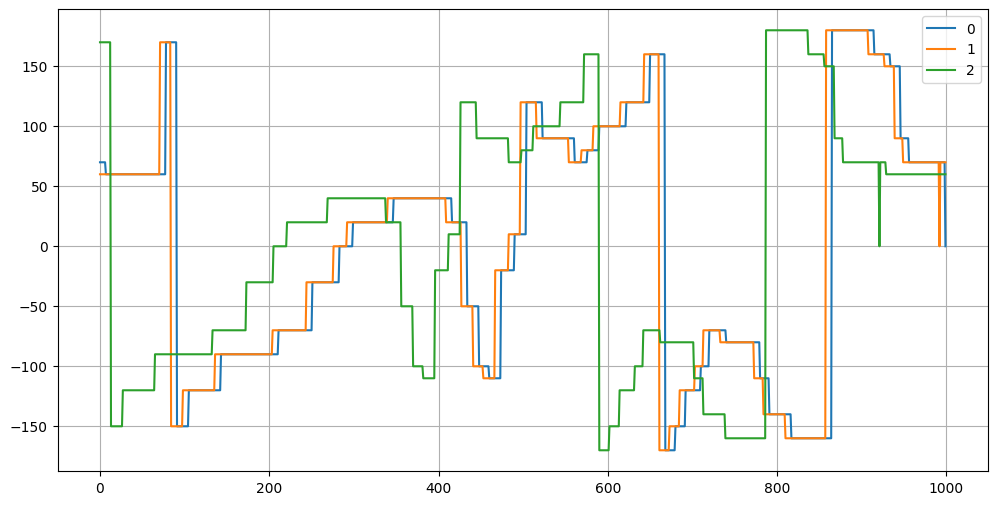

In [48]:
random_engram_id = RNG.choice(list(ENGRAM_DICT.keys()))
# random_engram_id = list(ENGRAM_DICT.keys())[0]
seq_lvs = ENGRAM_DICT[random_engram_id].seq_lvs[:3]

plt.figure(figsize=(12, 6))

for i, seq_lv_box in enumerate(seq_lvs):
    plt.plot(np.angle(seq_lv_box.lv, deg=True), label=str(i))
    
plt.grid()
plt.legend()
plt.show()

In [101]:
def get_image_with_sequences(image_id, df_images, highlight_si_inds=set(), normal_color='red', highlight_color='darkred', lowlight_color='gray'):
    df_image = df_images.loc[image_id]
    sensor_instance_ind_dict = pickle.loads(df_image['si'])
    sequences_full = pickle.loads(df_image['seq'])
    sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)

    image_png = df_image['png']
    image = Image.open(io.BytesIO(image_png))
    image = image.convert('RGB')
    k = image.size[0]
    image = image.resize((600, 600))
    k = image.size[0] / k
    image_draw = ImageDraw.Draw(image)

    sequences_si = [list(map(lambda si_ind: sensor_instance_ind_dict[si_ind], seq)) for seq in sequences]
    
    for seq in sequences_si:
        for si_from, si_to in zip(seq, seq[1:] + seq[:1]):
            pt_from = si_from.x * k, si_from.y * k
            pt_to = si_to.x * k, si_to.y * k
            image_draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill=normal_color)
            
            color = normal_color

            if highlight_si_inds:
                color = highlight_color if si_from.Index in highlight_si_inds else lowlight_color

            # print(color)
            
            nl = 8 * k
            image_draw.rectangle([pt_from[0]-1, pt_from[1]-1, pt_from[0]+1, pt_from[1]+1], outline=color)
            normal_vec = si_from.normal_vec
            image_draw.line([pt_from[0], pt_from[1], pt_from[0] + normal_vec.real * nl, pt_from[1] + normal_vec.imag * nl], width=1, fill=color)
            image_draw.text([pt_from[0] + normal_vec.real * nl*1.2, pt_from[1] + normal_vec.imag * nl*1.2], str(si_from.Index), anchor='mm', fill=color)

            color = normal_color
            
            if highlight_si_inds:
                color = highlight_color if si_to.Index in highlight_si_inds else lowlight_color
    
            image_draw.rectangle([pt_to[0]-1, pt_to[1]-1, pt_to[0]+1, pt_to[1]+1], outline=color)
            normal_vec = si_to.normal_vec
            image_draw.line([pt_to[0], pt_to[1], pt_to[0] + normal_vec.real * nl, pt_to[1] + normal_vec.imag * nl], width=1, fill=color)
            image_draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_to.Index), anchor='mm', fill=color)

    return image   

In [115]:
image_index = RNG.choice(df_train_images.index)
# image_index = 10710
df_image = df_train_images.loc[image_index]
sensor_instance_ind_dict = pickle.loads(df_image['si'])
sequences_full = pickle.loads(df_image['seq'])
sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)

In [116]:
si_ind_to_seq_index = {}

for seq_index, seq in enumerate(sequences):
    si_ind_to_seq_index.update(map(lambda si_ind: (si_ind, seq_index), seq))

sensor_instance_ind_to_latent_vector = calc_si_latent_vectors(sequences, sensor_instance_ind_dict)
connection_vectors_list = calc_si_connection_vectors(sequences, sensor_instance_ind_dict)
seq_lvs = []

for seq, connection_vectors in zip(sequences, connection_vectors_list):
    seq_lv, si_ind_to_offset = calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict)
    seq_lvs.append((seq_lv, si_ind_to_offset))

In [117]:
random_si_ind = RNG.choice(list(sensor_instance_ind_to_latent_vector.keys()))
# random_si_ind = 410
random_si_lv = sensor_instance_ind_to_latent_vector[random_si_ind]
seq_index = si_ind_to_seq_index[random_si_ind]
seq_lv, si_ind_to_offset = seq_lvs[seq_index]
seq_lv = np.roll(seq_lv, -si_ind_to_offset[random_si_ind])

cos_sims = LATENT_VECTORS.array_active @ random_si_lv
cos_sim_indices = np.argwhere(cos_sims > COS_SIM_45).ravel()
error_scores = defaultdict(list)

for cos_sim_index in cos_sim_indices:
    if ENGRAM_DICT[SEQ_LV_DICT[cos_sim_index].engram_id].image_id == image_index:
        continue
        
    candidate_seq_lv = SEQ_LV_DICT[cos_sim_index].lv

    seq_lv_diff = candidate_seq_lv - seq_lv
    error_score = np.sum(np.absolute(seq_lv_diff) ** 2)
    
    error_scores['cos_sim_index'].append(cos_sim_index)
    error_scores['candidate_engram_id'].append(SEQ_LV_DICT[cos_sim_index].engram_id)
    error_scores['candidate_seq_index'].append(SEQ_LV_DICT[cos_sim_index].seq_index)
    error_scores['candidate_image_id'].append(ENGRAM_DICT[SEQ_LV_DICT[cos_sim_index].engram_id].image_id)
    error_scores['candidate_value'].append(ENGRAM_DICT[SEQ_LV_DICT[cos_sim_index].engram_id].value)

    error_scores['image_id'].append(image_index)
    error_scores['value'].append(df_image['value'])
    error_scores['seq_index'].append(seq_index)
    
    error_scores['error_score'].append(error_score)

df_error_scores = pd.DataFrame(error_scores)
df_error_scores.sort_values(by=['error_score'], inplace=True)


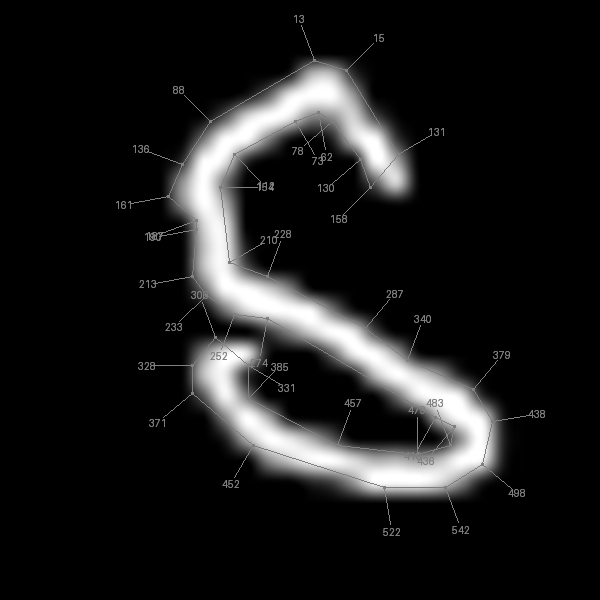
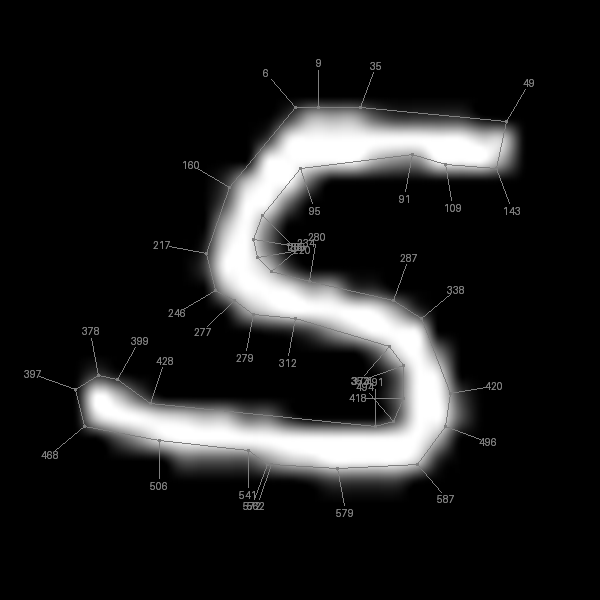

In [118]:
best_candidate_image_id = int(df_error_scores.iloc[0]['candidate_image_id'])
image1 = get_image_with_sequences(image_index, df_train_images, 
                                  #highlight_si_inds=[random_si_ind],
                                  normal_color='gray', highlight_color='red', lowlight_color='gray')
image2 = get_image_with_sequences(best_candidate_image_id, df_train_images, 
                                  # highlight_si_inds=engram_si_inds,
                                  # highlight_si_inds=set([185]), 
                                  normal_color='gray', highlight_color='lime', lowlight_color='gray')
display_images([image1, image2], captions=[f'{image_index}, {df_image['value']}', f'{engram.image_id}'])

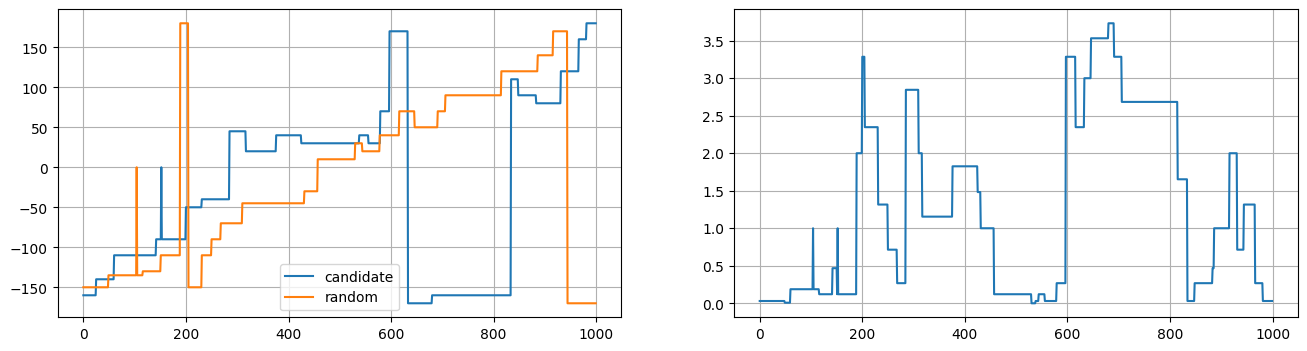

In [87]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(np.angle(candidate_seq_lv, deg=True), label='candidate')
plt.plot(np.angle(seq_lv, deg=True), label='random')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.absolute(seq_lv_diff) ** 2, label='diff')
plt.grid()
    
plt.show()

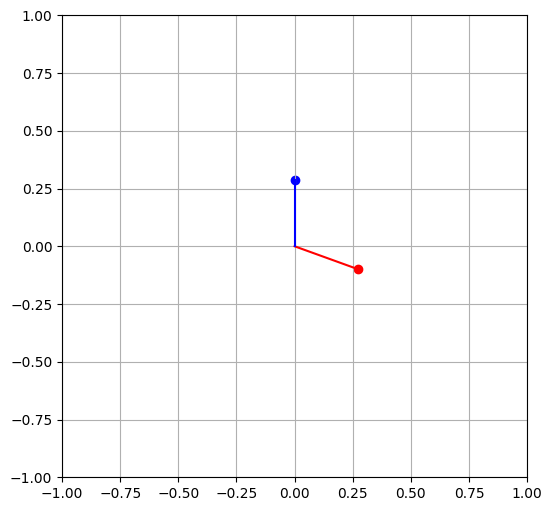

In [348]:
vec1 = [ 0.27126589,  0.09873271,  0.        , -0.28867513  ]

plt.figure(figsize=(6, 6))
plt.plot([0, vec1[0]], [0, -vec1[1]], 'r')
plt.scatter(vec1[0], -vec1[1], c='r')
plt.plot([0, vec1[2]], [0, -vec1[3]], 'b')
plt.scatter(vec1[2], -vec1[3], c='b')
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.grid()
plt.show()

In [ ]:
assert False

In [ ]:
%%time

train_runs = 2 * 50
attempts_to_get_no_mistakes = 10
count = min(1000, len(df_train_images))
consolidation_threshold = 1000

for _ in tqdm(range(train_runs)):
    TRAIN_RUN_ID += 1
    image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)
    
    for column_id, column in COLUMN_HOSTS.items():
        column.train_start(TRAIN_RUN_ID, image_ids, consolidation_threshold, attempts_to_get_no_mistakes)

    for column_id, column in COLUMN_HOSTS.items():
        column.train_finish()

In [ ]:
# TEST RUN
TEST_RUN_ID += 1
count = min(2000, len(test_run_source[0]))
# test_run_source = (df_test_images, test_db_con, 'test')
test_run_source = (df_train_images, train_db_con, 'train')
test_image_ids = RNG.choice(test_run_source[0].index.unique(), count, replace=False)
# test_image_ids = image_ids
test_result_rows = defaultdict(list)
column_id_whitelist = COLUMN_HOSTS.keys()
# column_id_whitelist = [3]
assert np.all(np.array(list(map(lambda i: i in COLUMN_HOSTS, column_id_whitelist))) == 1)

for image_id in tqdm(test_image_ids):
    image_value = test_run_source[0].loc[image_id]['value']
    column_votes_vectors = []
    column_votes_vector = np.zeros(10)
    column_images_seen = {}
    
    for column_id, column_host in COLUMN_HOSTS.items():
        if not column_id in column_id_whitelist:
            continue

        column_host.infer_start(image_id, test_run_source[2])

    for column_id, column_host in COLUMN_HOSTS.items():
        if not column_id in column_id_whitelist:
            continue

        column_votes_vector_, column_images_seen_ = column_host.infer_finish()
        column_votes_vector += column_votes_vector_
        column_votes_vectors.append(column_votes_vector_)
        column_images_seen.update(column_images_seen_)

    infer_value = ''
    
    if np.any(column_votes_vector) > 0:
        # digit_probabilities = softmax(column_votes_vector)
        # infer_value = str(RNG.choice(10, p=digit_probabilities))
        infer_value = str(np.argmax(column_votes_vector)) # softmax([0,0,0,0,0,0,0,0,0,4]) will produce probs [0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.9]
    
    test_result_rows['test_run_id'].append(TEST_RUN_ID)
    test_result_rows['config_variant'].append(config.section_name)
    test_result_rows['cortical_columns'].append(sorted(column_id_whitelist))
    test_result_rows['train_images_count'].append(max(list(column_images_seen.values())))
    test_result_rows['train_runs'].append(TRAIN_RUN_ID)
    test_result_rows['source_ds'].append(test_run_source[2])
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['infer_value'].append(infer_value) 
    test_result_rows['sim'].append(np.array(column_votes_vectors))
    

assert set(test_result_rows.keys()) == set(DF_TEST_RESULTS.columns), set(test_result_rows.keys()) ^ set(DF_TEST_RESULTS.columns)
df_test_results_for_run = pd.DataFrame(test_result_rows, columns=DF_TEST_RESULTS.columns)
concat_list = [DF_TEST_RESULTS] if len(DF_TEST_RESULTS) > 0 else []
concat_list.append(df_test_results_for_run)
DF_TEST_RESULTS = pd.concat(concat_list, ignore_index=True)

In [ ]:
df_test_results2 = DF_TEST_RESULTS.copy()
df_test_results2['is_infer'] = df_test_results2['infer_value'] != ''
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'config_variant': 'first', 
                                                                     'source_ds': 'first',
                                                                     'cortical_columns': 'first',
                                                                     'train_images_count': 'first',
                                                                     'train_runs': 'first',
                                                                     'test_image_id': 'count', 
                                                                     'is_infer': 'sum', 
                                                                     'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']
df_test_results2['accuracy_infers'] = df_test_results2['accuracy_infers'].fillna(0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2

In [ ]:
df = DF_TEST_RESULTS[DF_TEST_RESULTS.test_run_id == 1]
df_incorrect = df.loc[df.true_value != df.infer_value]
df_incorrect